#  Diabetic Retinopathy Detection

DataSet Link: https://www.kaggle.com/competitions/diabetic-retinopathy-detection/data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import applications
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from numpy import asarray
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import warnings
warnings.filterwarnings("ignore")

In [ ]:
os.listdir('../input/retinopathy/DR data')

['Mild', 'Proliferate_DR', 'Moderate', 'No_DR', 'Severe']

In [ ]:
train = []
label = []

for i in os.listdir('../input/retinopathy/DR data'):
  train_class = os.listdir(os.path.join('../input/retinopathy/DR data', i))
  for j in train_class:
    img_path = os.path.join('../input/retinopathy/DR data', i, j)
    train.append(img_path)
    label.append(i)

print('Number of images available in the dataset: {} \n'.format(len(train)))


Number of images available in the dataset: 3662 



In [ ]:
train[1:6]

['../input/retinopathy/DR data/Mild/abdb365cacbc.png',
 '../input/retinopathy/DR data/Mild/33ffddea8c6e.png',
 '../input/retinopathy/DR data/Mild/059bc89df7f4.png',
 '../input/retinopathy/DR data/Mild/278aa860dffd.png',
 '../input/retinopathy/DR data/Mild/d66b6f333dc7.png']

In [ ]:
print(label[1:2])
#print(label[3000:3001])
#label

['Mild']
['No_DR']


# Data visualization

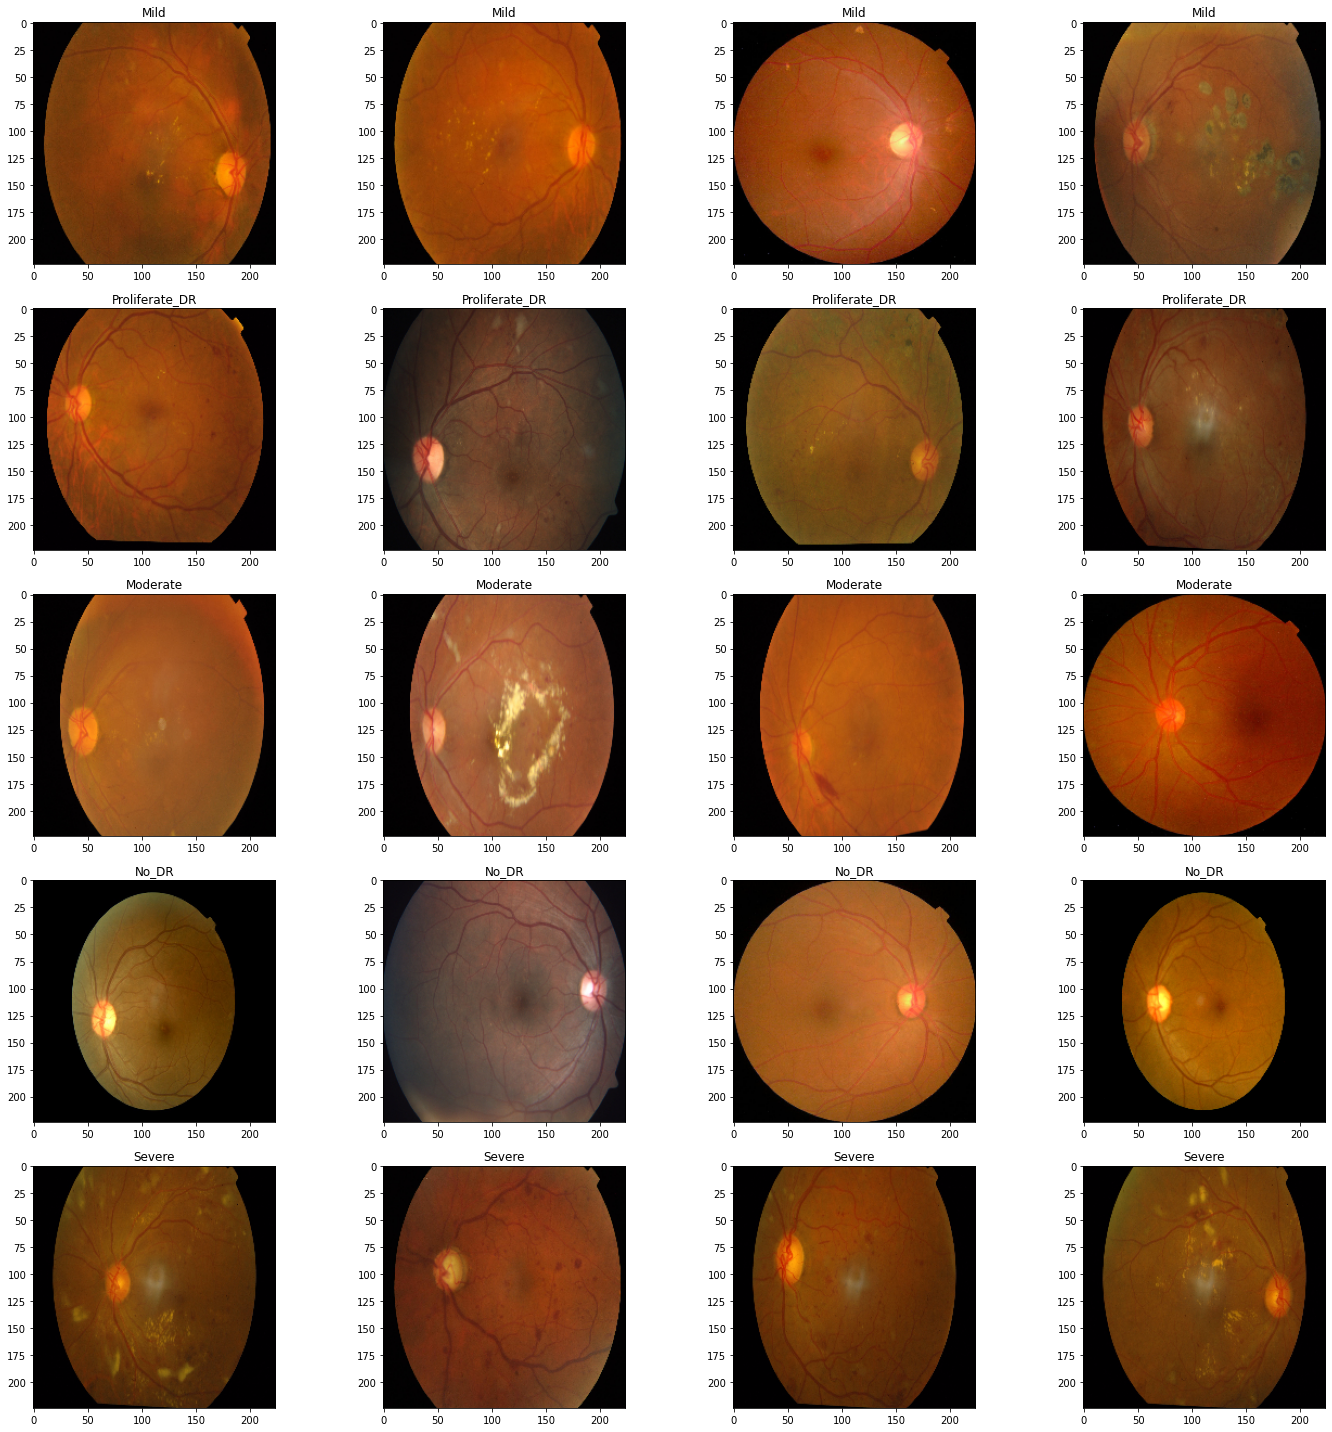

In [ ]:
fig, axs = plt.subplots(5, 4, figsize = (20, 20))
count = 0
for i in os.listdir('../input/retinopathy/DR data'):
    train_class = os.listdir(os.path.join('../input/retinopathy/DR data', i))
    for j in range(4):
        img = os.path.join('../input/retinopathy/DR data', i, train_class[j])
        img = PIL.Image.open(img)
        axs[count][j].title.set_text(i)
        axs[count][j].imshow(img)
    count += 1

fig.tight_layout()

In [ ]:
No_images_per_class = []
Class_name = []
for i in os.listdir('../input/retinopathy/DR data'):
  train_class = os.listdir(os.path.join('../input/retinopathy/DR data', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in Mild = 370 

Number of images in Proliferate_DR = 295 

Number of images in Moderate = 999 

Number of images in No_DR = 1805 

Number of images in Severe = 193 



In [ ]:
retina_df = pd.DataFrame({'Image': train,'Labels': label})
retina_df.head()

Image Labels
0  ../input/retinopathy/DR data/Mild/f481f76a6b75...   Mild
1  ../input/retinopathy/DR data/Mild/abdb365cacbc...   Mild
2  ../input/retinopathy/DR data/Mild/33ffddea8c6e...   Mild
3  ../input/retinopathy/DR data/Mild/059bc89df7f4...   Mild
4  ../input/retinopathy/DR data/Mild/278aa860dffd...   Mild

In [ ]:
retina_df.tail()

Image  Labels
3657  ../input/retinopathy/DR data/Severe/457c7c927e...  Severe
3658  ../input/retinopathy/DR data/Severe/24b87f7445...  Severe
3659  ../input/retinopathy/DR data/Severe/a8e88d4891...  Severe
3660  ../input/retinopathy/DR data/Severe/4c60b10a3a...  Severe
3661  ../input/retinopathy/DR data/Severe/e13412678e...  Severe

<AxesSubplot:ylabel='count'>

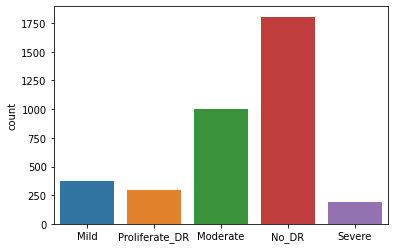

In [ ]:
sns.countplot(label)

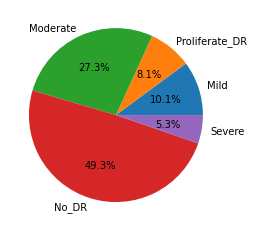

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(No_images_per_class, labels = Class_name, autopct = '%1.1f%%')
plt.show()

In [ ]:
df = retina_df.copy()
df.head()

Image Labels
0  ../input/retinopathy/DR data/Mild/f481f76a6b75...   Mild
1  ../input/retinopathy/DR data/Mild/abdb365cacbc...   Mild
2  ../input/retinopathy/DR data/Mild/33ffddea8c6e...   Mild
3  ../input/retinopathy/DR data/Mild/059bc89df7f4...   Mild
4  ../input/retinopathy/DR data/Mild/278aa860dffd...   Mild

# Data Augmentation and Data Generator creation

In [ ]:
# limiting maximum number of samples in a class to 1600
"""
sample_list=[]
max_size= 1700
groups=df.groupby('Labels')
for label in df['Labels'].unique():
    group=groups.get_group(label)
    sample_count=len(group)
    if sample_count> max_size:
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
    else:
        samples=group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
    sample_list.append(samples)
df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(df))
print (df['Labels'].value_counts())
"""


"\nsample_list=[]\nmax_size= 1700\ngroups=df.groupby('Labels')\nfor label in df['Labels'].unique():                 \n    group=groups.get_group(label)\n    sample_count=len(group)    \n    if sample_count> max_size:\n        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)\n    else:\n        samples=group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)\n    sample_list.append(samples)\ndf=pd.concat(sample_list, axis=0).reset_index(drop=True)\nprint (len(df))     \nprint (df['Labels'].value_counts())     \n"

In [ ]:
# creating new aug directory for augmented images of classes with less than 370 samples
working_dir='/kaggle/working/'
aug_dir=os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in df['Labels'].unique():
    dir_path=os.path.join(aug_dir,label)
    os.mkdir(dir_path)
print(os.listdir(aug_dir))

['No_DR', 'Proliferate_DR', 'Moderate', 'Severe', 'Mild']


In [ ]:
# creating augmented images that will store in the newly created aug directory
target=1820 # set the target count for each class in df
gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                              height_shift_range=.2, zoom_range=.2)
groups=df.groupby('Labels') # group by class
for label in df['Labels'].unique():  # for every class
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label
    sample_count=len(group)   # determine how many samples there are in this class
    if sample_count< target: # if the class has less than target number of images
        aug_img_count=0
        delta=target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images
        aug_gen=gen.flow_from_dataframe( group,  x_col='Image', y_col=None, target_size=(224,224), class_mode=None,
                                        batch_size=1, shuffle=False, save_to_dir=target_dir, save_prefix='aug-',
                                        save_format='jpg')
        while aug_img_count<delta:
            images=next(aug_gen)
            aug_img_count += len(images)

Found 370 validated image filenames.
Found 295 validated image filenames.
Found 999 validated image filenames.
Found 1805 validated image filenames.
Found 193 validated image filenames.


In [ ]:
aug='/kaggle/working/aug'
auglist=os.listdir(aug)
print (auglist)
for i in auglist:
    classpath=os.path.join(aug, i)
    flist=os.listdir(classpath)
    print('class: ', i, '  file count: ', len(flist))

['No_DR', 'Proliferate_DR', 'Moderate', 'Severe', 'Mild']
class:  No_DR   file count:  15
class:  Proliferate_DR   file count:  1525
class:  Moderate   file count:  821
class:  Severe   file count:  1627
class:  Mild   file count:  1450


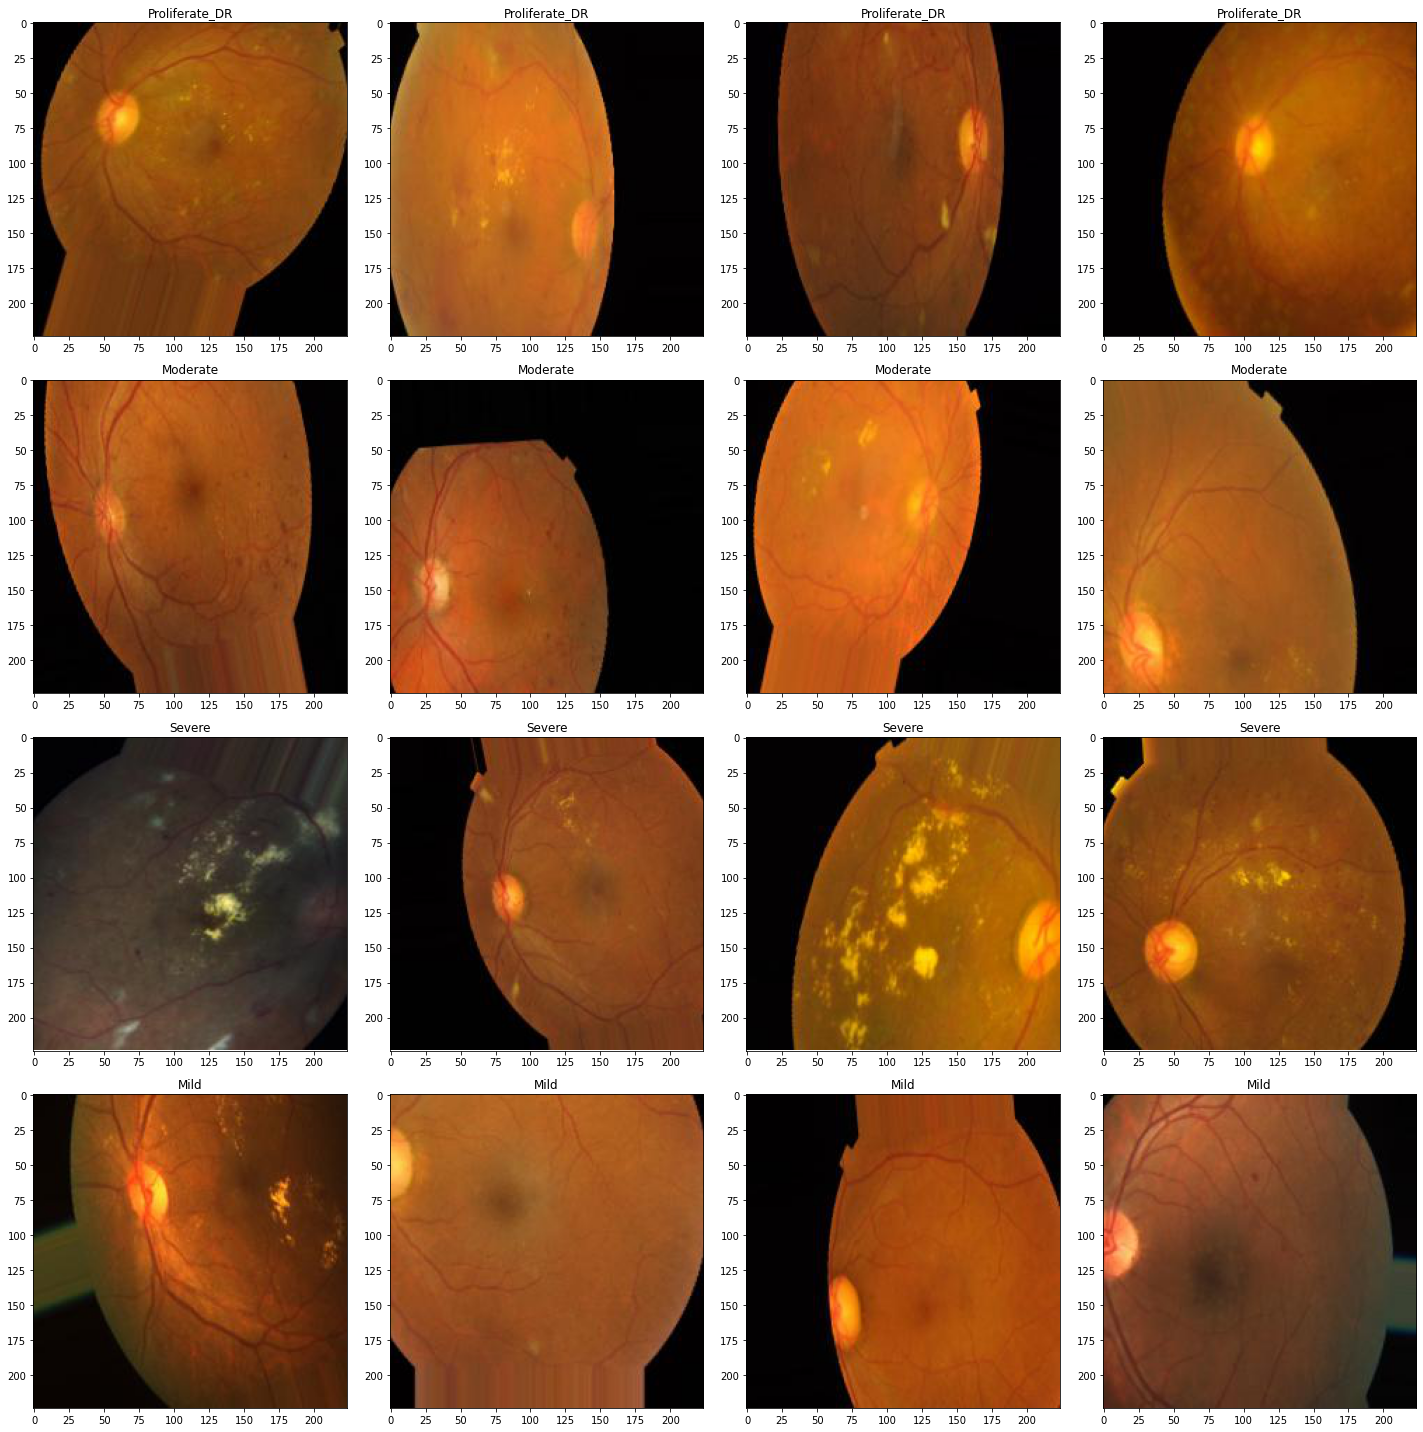

In [ ]:
# Displaying some created augmented images from aug directory

fig, axs = plt.subplots(4, 4, figsize = (20, 20))
count = 0
for i in os.listdir('/kaggle/working/aug'):
    train_class = os.listdir(os.path.join('/kaggle/working/aug', i))
    for j in range(4):
        if i!='No_DR':
            img = os.path.join('/kaggle/working/aug', i, train_class[j])
            img = PIL.Image.open(img)
            axs[count][j].title.set_text(i)
            axs[count][j].imshow(img)
    if i!='No_DR':
        count += 1

fig.tight_layout()

In [ ]:
# create new aug_df and concatenate with original df
aug_fpaths=[]
aug_labels=[]
classlist=os.listdir(aug_dir)
for i in classlist:
    classpath=os.path.join(aug_dir, i)
    flist=os.listdir(classpath)
    for f in flist:
        fpath=os.path.join(classpath,f)
        aug_fpaths.append(fpath)
        aug_labels.append(i)
Fseries=pd.Series(aug_fpaths, name='Image')
Lseries=pd.Series(aug_labels, name='Labels')
aug_df=pd.concat([Fseries, Lseries], axis=1)
ndf=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
#ndf=df.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)


print (df['Labels'].value_counts())
print(aug_df['Labels'].value_counts())
print (ndf['Labels'].value_counts())

No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: Labels, dtype: int64
Severe            1627
Proliferate_DR    1525
Mild              1450
Moderate           821
No_DR               15
Name: Labels, dtype: int64
Mild              1820
Proliferate_DR    1820
Moderate          1820
No_DR             1820
Severe            1820
Name: Labels, dtype: int64


In [ ]:
ndf.head()

Image Labels
0  ../input/retinopathy/DR data/Mild/f481f76a6b75...   Mild
1  ../input/retinopathy/DR data/Mild/abdb365cacbc...   Mild
2  ../input/retinopathy/DR data/Mild/33ffddea8c6e...   Mild
3  ../input/retinopathy/DR data/Mild/059bc89df7f4...   Mild
4  ../input/retinopathy/DR data/Mild/278aa860dffd...   Mild

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

ndf = shuffle(ndf)
train, test = train_test_split(ndf, test_size = 0.2)
train.head()

Image    Labels
2735  ../input/retinopathy/DR data/No_DR/4926dea289f...     No_DR
1155  ../input/retinopathy/DR data/Moderate/681c3c11...  Moderate
8939       /kaggle/working/aug/Mild/aug-_21_6044895.jpg      Mild
6424    /kaggle/working/aug/Severe/aug-_111_2052442.jpg    Severe
6576      /kaggle/working/aug/Severe/aug-_5_5053050.jpg    Severe

In [ ]:
def crop_image_from_gray(img, tol=7):

    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]

        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
            return img

In [ ]:
def preprocess_fun(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted(image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        validation_split = 0.15,
        horizontal_flip=True,
        preprocessing_function = preprocess_fun
)

test_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function = preprocess_fun)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical", #raw
    batch_size=32,
    subset='training')

Found 6188 validated image filenames belonging to 5 classes.


In [ ]:
validation_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='validation')

Found 1092 validated image filenames belonging to 5 classes.


In [ ]:

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

Found 1820 validated image filenames belonging to 5 classes.


# Building Model


In [ ]:
img_shape = (224,224,3)

model_name='EfficientNetB1'

base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

x=base_model.output

x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)

x=Dropout(rate=.50, seed=123)(x)

output=Dense(5, activation='softmax')(x)

model=Model(inputs=base_model.input, outputs=output)

#model.summary()

2022-03-19 17:26:06.457928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 17:26:06.532334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 17:26:06.533149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 17:26:06.534875: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

27033600/27018416 [==============================] - 0s 0us/step


# Compilation and Training of Model

In [ ]:
#model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics= ['accuracy'])
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])

In [ ]:


earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

checkpointer = ModelCheckpoint(filepath="EfficientNet_weights.hdf5", verbose=1, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

In [ ]:
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = 100, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , reduce_lr, earlystopping], )
#class_weight=class_weight

2022-03-19 17:26:12.770529: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-03-19 17:26:25.814592: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


193/193 [==============================] - 173s 802ms/step - loss: 6.8061 - accuracy: 0.5687 - val_loss: 6.0877 - val_accuracy: 0.2206

Epoch 00001: val_loss improved from inf to 6.08770, saving model to EfficientNet_weights.hdf5
Epoch 2/100
193/193 [==============================] - 147s 760ms/step - loss: 4.3342 - accuracy: 0.6673 - val_loss: 4.3030 - val_accuracy: 0.2289

Epoch 00002: val_loss improved from 6.08770 to 4.30298, saving model to EfficientNet_weights.hdf5
Epoch 3/100
193/193 [==============================] - 146s 755ms/step - loss: 2.9271 - accuracy: 0.7211 - val_loss: 3.3869 - val_accuracy: 0.2858

Epoch 00003: val_loss improved from 4.30298 to 3.38695, saving model to EfficientNet_weights.hdf5
Epoch 4/100
193/193 [==============================] - 146s 754ms/step - loss: 1.9653 - accuracy: 0.7978 - val_loss: 2.6771 - val_accuracy: 0.2868

Epoch 00004: val_loss improved from 3.38695 to 2.67709, saving model to EfficientNet_weights.hdf5
Epoch 5/100
193/193 [===========

In [ ]:
history.history['val_loss']

[6.087703704833984,
 4.302975177764893,
 3.386948585510254,
 2.6770901679992676,
 2.268630027770996,
 2.1571123600006104,
 1.3424841165542603,
 1.819106101989746,
 1.830500602722168,
 1.8064926862716675,
 1.280076026916504,
 1.0377569198608398,
 1.4936151504516602,
 1.4349733591079712,
 1.84614098072052,
 0.5526192784309387,
 0.9282289147377014,
 1.3597297668457031,
 0.7214329242706299,
 0.5339017510414124,
 0.6526894569396973,
 0.4359518885612488,
 0.5025787353515625,
 0.4415569603443146,
 0.4399312138557434,
 0.5857136845588684,
 0.49091097712516785,
 0.5112261772155762,
 0.674267053604126,
 0.6200323104858398,
 0.6670683026313782,
 0.5390716195106506,
 0.46743834018707275,
 0.7759785652160645,
 0.4814704358577728,
 0.637287437915802,
 0.5302091240882874,
 0.6216155290603638,
 0.5077471137046814,
 0.4643760323524475,
 0.46581947803497314,
 0.5028238892555237,
 0.4396206736564636,
 0.38889816403388977,
 0.4684266448020935,
 0.5778899192810059,
 0.4008324146270752,
 0.49141445755958557

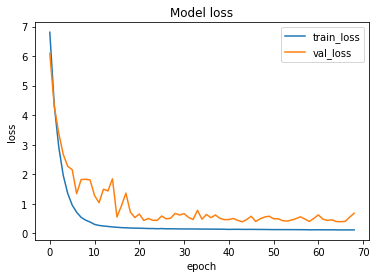

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

# Assessment of Trained model

In [ ]:
model.load_weights("EfficientNet_weights.hdf5")

In [ ]:
#sns.set(font_scale=3.0)

In [ ]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

56/56 [==============================] - 17s 296ms/step - loss: 0.4316 - accuracy: 0.8990
Accuracy Test : 0.8989955186843872


In [ ]:
labels = {0: 'Mild', 1: 'Moderate', 2: 'No_DR', 3:'Proliferate_DR', 4: 'Severe'}

In [ ]:

prediction = []
original = []
image = []
count = 0

for item in range(len(test)):
    img = PIL.Image.open(test['Image'].tolist()[item])
    img =  preprocess_fun(asarray(img))
    image.append(img)
    img = np.asarray(img, dtype= np.float32)
    img = img / 255
    img = img.reshape(-1,224,224,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(labels[predict])
    original.append(test['Labels'].tolist()[item])


In [ ]:
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.8824175824175824


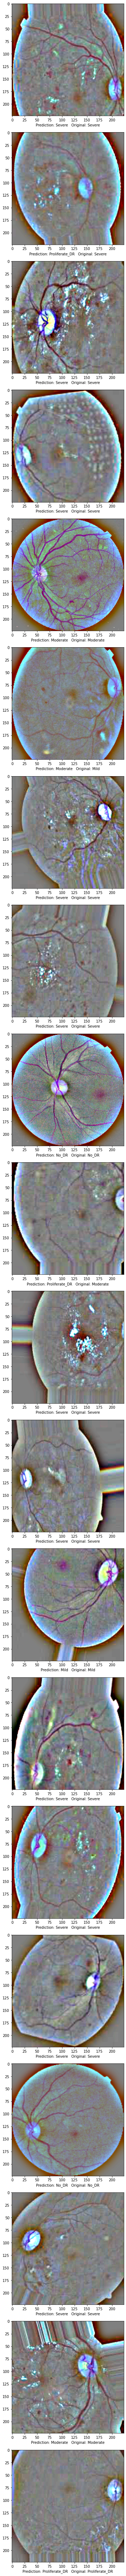

In [ ]:
import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + str(prediction[j]) +"   Original: " + str(original[j]))
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

                precision    recall  f1-score   support

          Mild       0.86      0.87      0.86       352
      Moderate       0.84      0.74      0.79       366
         No_DR       0.96      0.97      0.97       332
Proliferate_DR       0.84      0.92      0.87       377
        Severe       0.92      0.92      0.92       393

      accuracy                           0.88      1820
     macro avg       0.88      0.88      0.88      1820
  weighted avg       0.88      0.88      0.88      1820



Text(0.5, 1.0, 'Confusion_matrix')

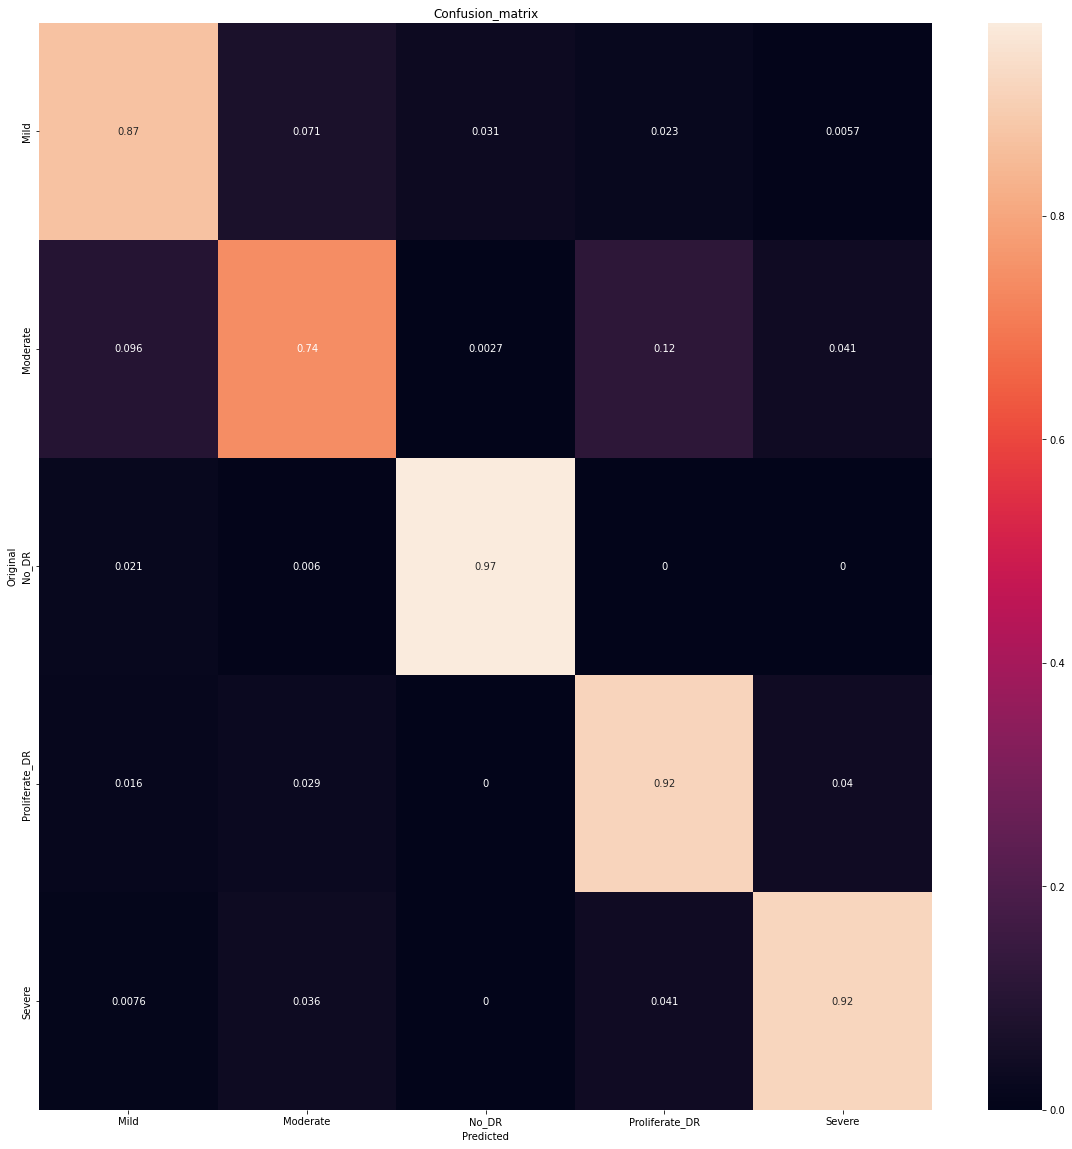

In [ ]:
# Confusion matrix
plt.figure(figsize = (20,20))
cm = confusion_matrix(original,prediction, normalize='true')
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, xticklabels=['Mild','Moderate','No_DR','Proliferate_DR','Severe'], yticklabels=['Mild','Moderate','No_DR','Proliferate_DR','Severe'])
# xticklabels=['Mild','Moderate','No_DR','Proliferate_DR','Severe'], yticklabels=['Mild','Moderate','No_DR','Proliferate_DR','Severe']
ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')
